<center style><h3>Computer Assignment 5 - phase 1</h3></center>
<center style><h4>Neural Network - Feed Forward</h4></center>
 <h4 style="text-align:right">
        محمد پویا افشاری - 810198577
</h4>


# MLP from scratch


In this homework, you will code a [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) with one hidden layer to classify text data.

Advice:

- As much as possible, please try to make matrix and vector operations (good practice for efficient code)
- If you're not familiar with numpy, check the documentation of `np.max`, `np.clip`, `np.random.randn`, `np.reshape`. FYI the matrix multiplication operator is `@`, and you may want to learn about [broadcasting rules](https://numpy.org/doc/stable/user/basics.broadcasting.html) to see how it deals with tensor operations of different sizes
- You can also check about `torch.clamp`, `torch.nn.Parameter`

## 1. Some utilities and dataset for Part 2


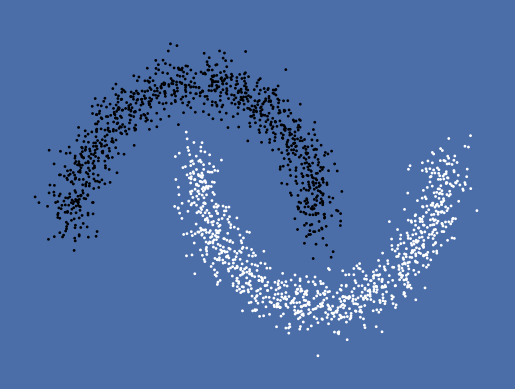

In [116]:
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Plot the dataset


def plot_data(ax, X, Y):
    plt.axis('off')
    ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap='bone')


X, Y = make_moons(n_samples=2000, noise=0.1)

%matplotlib inline
x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_data(ax, X, Y)
plt.show()


In [117]:
# Define the grid on which we will evaluate our classifier
xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                     np.arange(y_min, y_max, .1))

to_forward = np.array(list(zip(xx.ravel(), yy.ravel())))

# plot the decision boundary of our classifier


def plot_decision_boundary(ax, X, Y, classifier):
    # forward pass on the grid, then convert to numpy for plotting

    Z = classifier.forward(to_forward)
    Z = Z.reshape(xx.shape)

    # plot contour lines of the values of our classifier on the grid
    ax.contourf(xx, yy, Z > 0.5, cmap='Blues')

    # then plot the dataset
    plot_data(ax, X, Y)


## 2. MLP in numpy

Here you need to code your implementation of the [ReLU](<https://en.wikipedia.org/wiki/Rectifier_(neural_networks)>) activation and the [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function).


In [118]:
class MyReLU(object):
    def forward(self, x):
        # the relu is y_i = max(0, x_i)
        self.x = x
        return np.maximum(0, x)

    def backward(self, grad_output):
        # the gradient is 1 for the inputs that were above 0, 0 elsewhere
        return grad_output * (np.array(self.x) > 0)

    def step(self, learning_rate):
        # no need to do anything here, since ReLU has no parameters
        pass


class MySigmoid(object):
    def forward(self, x):
        # the sigmoid is y_i = 1./(1+exp(-x_i))
        self.x = x
        return 1 / (1 + np.exp(-x))

    def backward(self, grad_output):
        # the partial derivative is e^-x / (e^-x + 1)^2
        sigmoid = self.forward(self.x)
        return grad_output * sigmoid * (1 - sigmoid)

    def step(self, learning_rate):
        # no need to do anything here since Sigmoid has no parameters
        pass


Probably a good time to test your functions...


In [119]:
test_relu = MyReLU()
test_relu.forward([0, -1, 0.5, -0.5, 0.8, 1])


array([0. , 0. , 0.5, 0. , 0.8, 1. ])

In [120]:
test_relu.backward(np.ones(1))


array([0., 0., 1., 0., 1., 1.])

In [121]:
test_sig = MySigmoid()

test_sig.forward(np.ones(1))


array([0.73105858])

In [122]:
test_sig.backward(np.ones(1))


array([0.19661193])

A bit more complicated, you need now to implement your linear layer i.e. multiplication by a matrix W and summing with a bias b.


In [123]:
class MyLinear(object):
    def __init__(self, n_input, n_output):
        # initialize two random matrices for W and b (use np.random.randn)
        self.W = np.random.randn(n_input, n_output)
        self.b = np.random.randn(n_output)

    def forward(self, x):
        # save a copy of x, you'll need it for the backward
        self.x = x.copy()
        # return Wx + b
        return np.dot(x, self.W) + self.b

    def backward(self, grad_output):
        dW = np.dot(grad_output.T, self.x)
        db = grad_output
        dx = np.dot(grad_output, self.W.T)
        return dx, dW, db

    def step(self, learning_rate):
        # update self.W and self.b in the opposite direction of the stored gradients, for learning_rate
        self.W -= learning_rate * self.dW
        self.b -= learning_rate * self.db


Code your network. Note that with a Sigmoid layer, you should use the Binary Cross Entropy (BCE) loss.


In [124]:
class Sequential(object):
    def __init__(self):
        # Specify your model's Architecture here (Use your Linear and Activation Functions)
        self.layers = []

    def add_layer(self, layer):
        # Add a layer to the model
        self.layers.append(layer)

    def forward(self, x):
        # Forward pass through the layers
        output = x
        for layer in self.layers:
            output = layer.forward(output)
        return output

    def compute_loss(self, out, label):
        # Compute Binary Cross Entropy (BCE) loss
        loss = -(label * np.log(out + 1e-10) +
                 (1 - label) * np.log(1 - out + 1e-10))
        gradient = -((label / (out + 1e-10)) -
                     ((1 - label) / (1 - out + 1e-10)))
        return loss, gradient

    def backward(self, gradient):
        # Backward pass through the layers
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)

    def step(self, learning_rate):
        # Update the parameters of each layer
        for layer in self.layers:
            layer.step(learning_rate)


In [125]:
n_input = X.shape[1]
hidden_size = 50
output_size = 1


network = Sequential()

# Add layers to the network
network.add_layer(MyLinear(n_input, hidden_size))
network.add_layer(MyReLU())
network.add_layer(MyLinear(hidden_size, output_size))
network.add_layer(MySigmoid())


In [126]:
losses = []
learning_rate = 1e-2
epochs = 10

for epoch in range(epochs):
    for it in range(len(X)):
        # pick a random example idx
        idx = np.random.randint(len(X))

        # select the corresponding example and label
        example = X[idx]
        label = Y[idx]

        # do a forward pass on the example
        output = network.forward(example)

        # compute the loss according to your output and the label
        loss = network.compute_loss(output, label)
        losses.append(loss)

        # backward pass
        gradient = 1.0
        network.backward(gradient)

        # gradient step
        network.step(learning_rate)


ValueError: shapes (1,) and (50,) not aligned: 1 (dim 0) != 50 (dim 0)

ValueError: x and y can be no greater than 2D, but have shapes (1,) and (1, 2, 1)

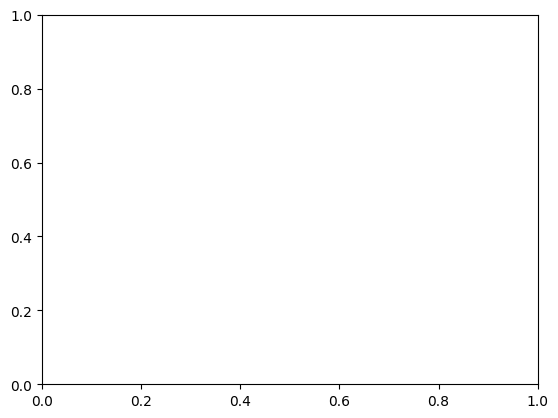

In [ ]:
%matplotlib inline
plt.plot(losses)
plt.show()


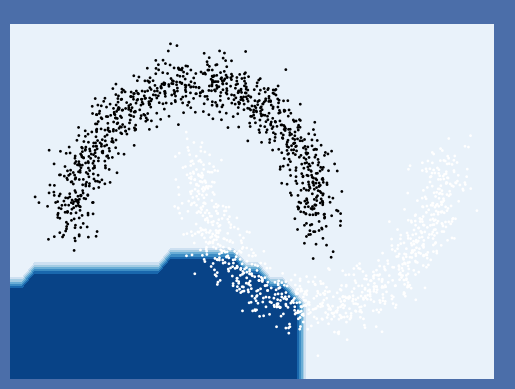

In [132]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_decision_boundary(ax, X, Y, network)
fig.canvas.draw()
